In [11]:
import os, sys, copy, time, math, random, numbers, itertools, tqdm, importlib, re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rasterio
import torch
import yaml

from sklearn import metrics
from skimage import transform as trans
from pathlib import Path
from collections.abc import Sequence
from datetime import datetime, timedelta
from scipy.ndimage import rotate
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# The code cell is used to add the src directory to the Python path, making 
# it possible to import modules from that directory. 

module_path = os.path.abspath(os.path.join('../src'))
sys.path.insert(0, module_path)

In [3]:
from custom_dataset import CropData
from models.unet import Unet
from model_compiler import ModelCompiler
from custom_loss_functions import *
from utils import *

In [12]:
class SatelliteData(Dataset):
    
    def __init__(self, 
                 truth_dir, mask_dir):
        self.truth_dir = Path(truth_dir)
        self.mask_dir = Path(mask_dir)
        self.truth_paths = self._get_truth_paths()
        self.mask_paths = self._get_mask_paths()


    def _get_truth_paths(self):
        tif_paths = [self.truth_dir.joinpath(i) for i in os.listdir(self.mask_dir) if i.endswith('.tif')]
        return tif_paths

    def _get_mask_paths(self):
        mask_paths = [self.mask_dir.joinpath(i) for i in os.listdir(self.mask_dir) if i.endswith('.tif')]
        return mask_paths
    
    def __len__(self):
        return len(self.truth_paths)

    def __getitem__(self, index):
        def read_tif_as_np_array(path):
            with rasterio.open(path) as src:
                    return src.read()
                
        # Read in merged tif as ground truth
        groundtruth = read_tif_as_np_array(self.truth_paths[index])
        groundtruth = torch.tensor(groundtruth, dtype=torch.uint8)
        mask = read_tif_as_np_array(self.mask_paths[index])
        mask = torch.tensor(mask, dtype=torch.uint8)
        
        return groundtruth, mask 

In [53]:
image_dataset = SatelliteData(truth_dir = '/home/data/kenya/labels/', mask_dir = '/home/workdir/kenya_output_skipatt/sam_predictions/')

# data loader
image_loader = DataLoader(image_dataset, 
                          batch_size  = 1, 
                          shuffle     = False)

In [54]:
from sam_accuracy import do_accuracy_evaluation 

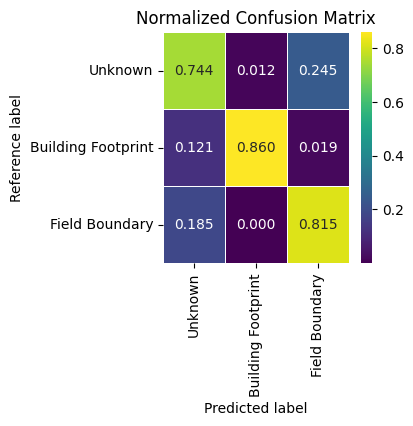

In [55]:
metrics = do_accuracy_evaluation(image_loader, 3, {0: 'Unknown', 1: 'Building Footprint', 2: 'Field Boundary'})

In [56]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(metrics.items()), columns=['metric', 'value'])

# Save DataFrame to CSV
df.to_csv('/home/workdir/kenya_output_skipatt/test_sam_metrics.csv', index=False)